In [7]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import json
path = Path('Classificatior_data/')
pathv1 = path / Path('ch0Mask')
pathv2 = path / Path('inChannelDist')
pathv3 = path / Path('noPretrain')
pathv4 = path / Path('semi_pretrain_only_Pretrain')
pathv5 = path / Path('semi_pretrain_transfer')
#pathv2 = Path('Classificatior_data/ch0Mask')
if not pathv1.exists():
    print("No data found in the specified path.")
if not pathv2.exists():
    print("No data found in the specified path.")
if not pathv3.exists():
    print("No data found in the specified path.")
if not pathv4.exists():
    print("No data found in the specified path.")

path = pathv1

In [12]:
#import re
#
#jsons = sorted(
#    path.glob('*.json'),
#    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
#)
#
#print(f'Found {len(jsons)} JSON files in {path}')
#
#histories = []
#for json_file in jsons:
#    print(f'Reading {json_file}')
#    with open(json_file, 'r') as file:
#        histories.append(file.read())
#

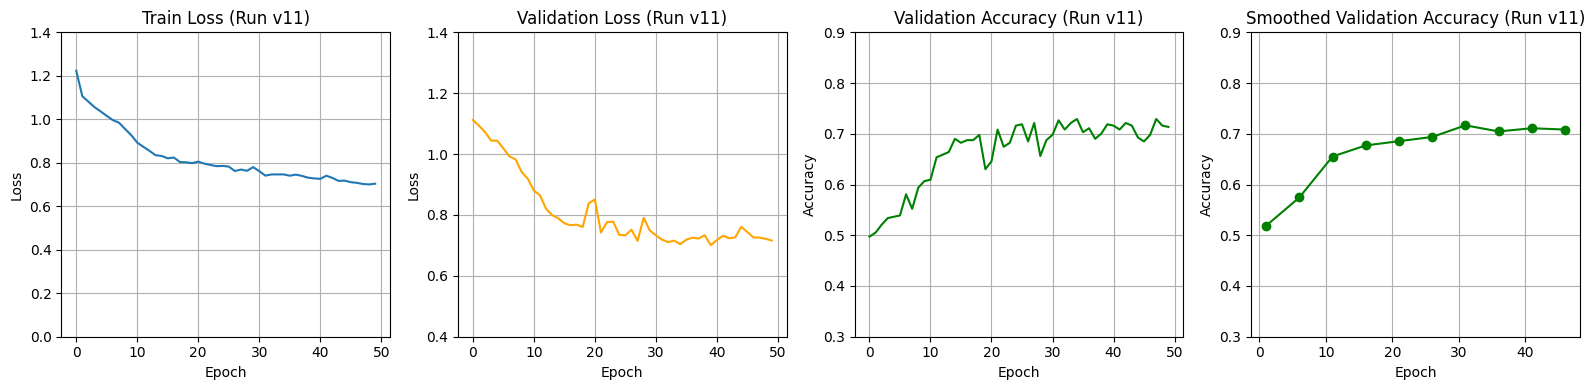

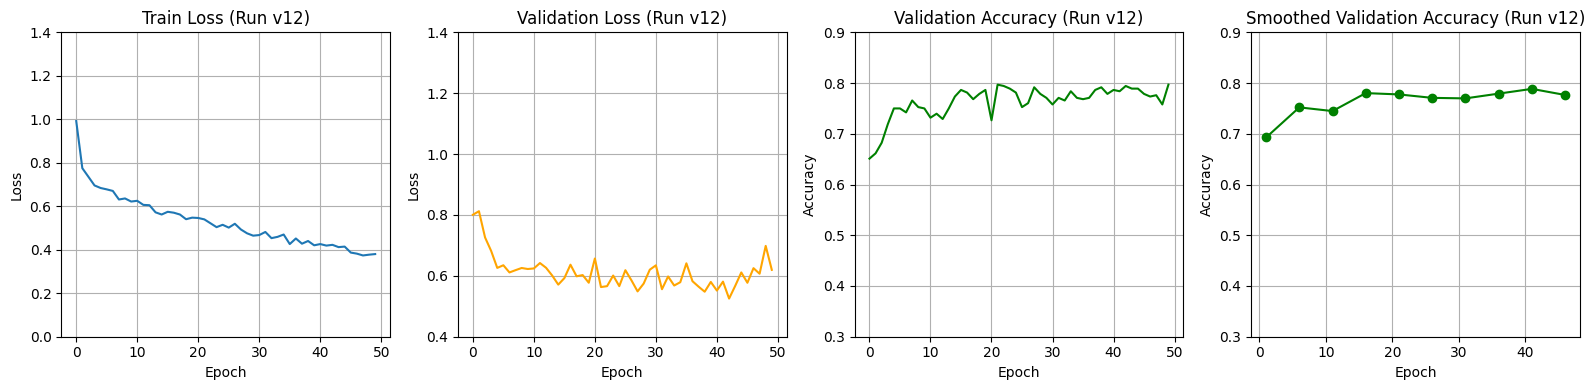

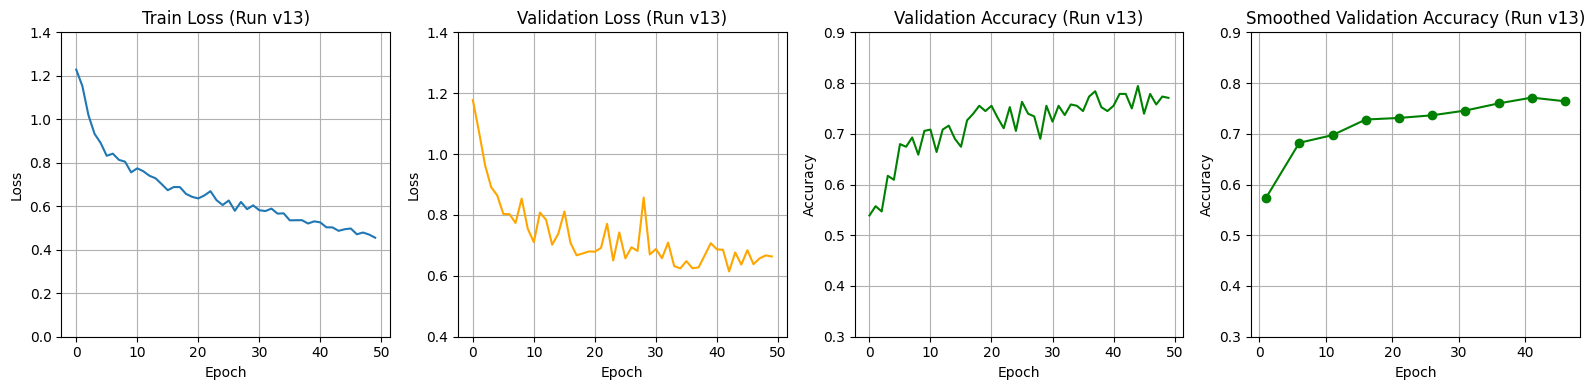

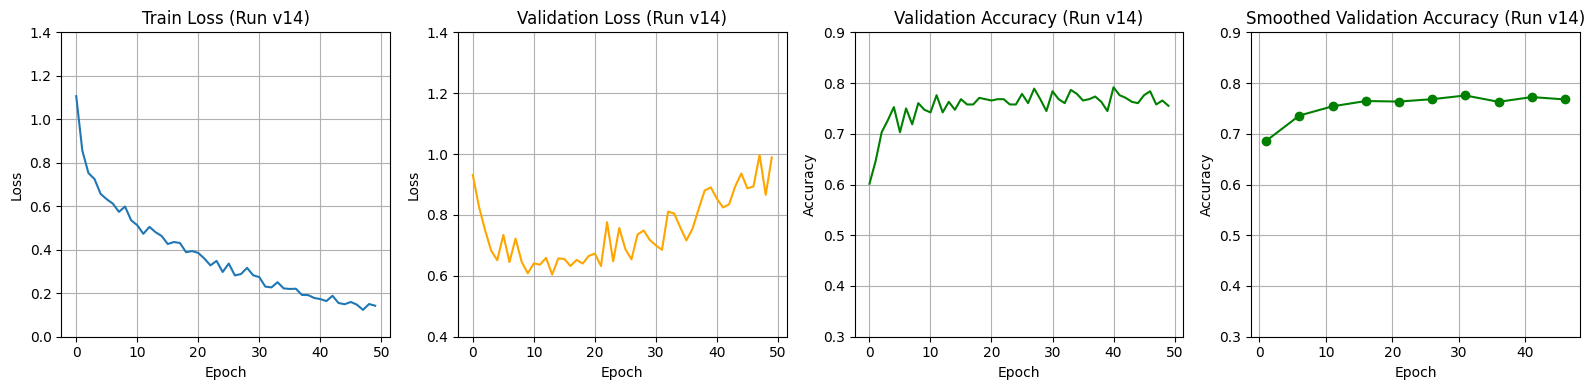

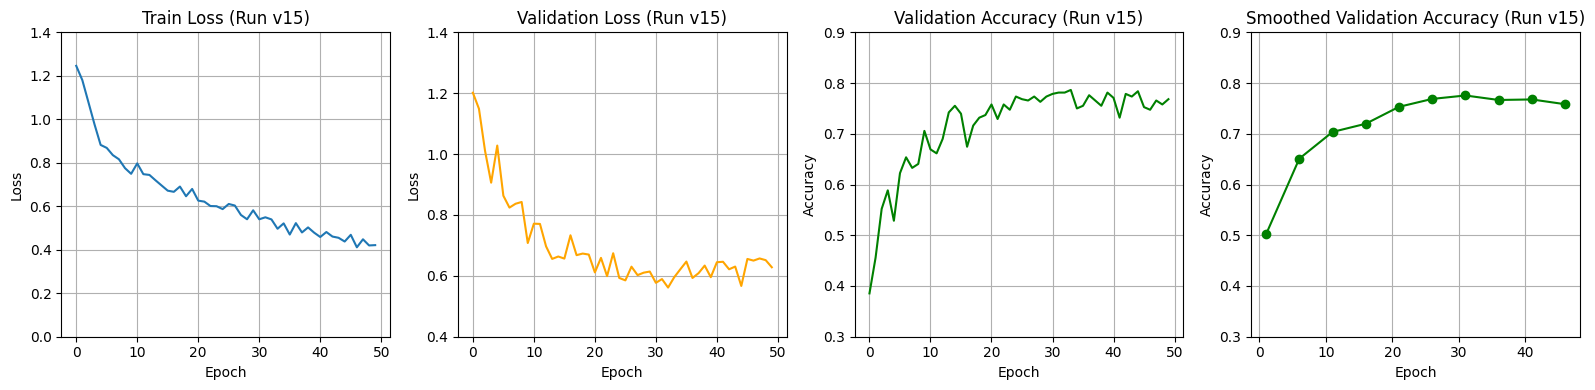

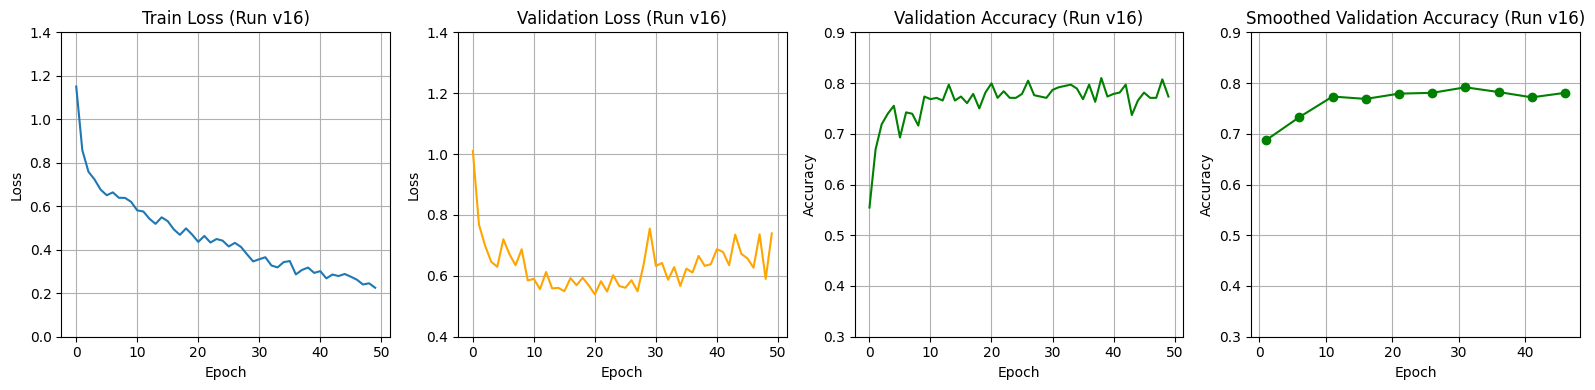

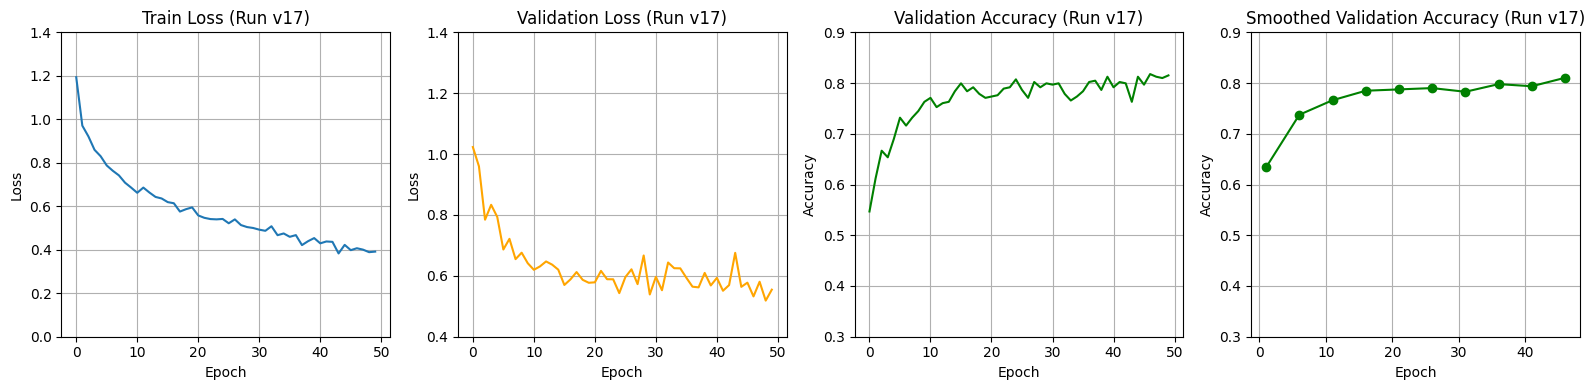

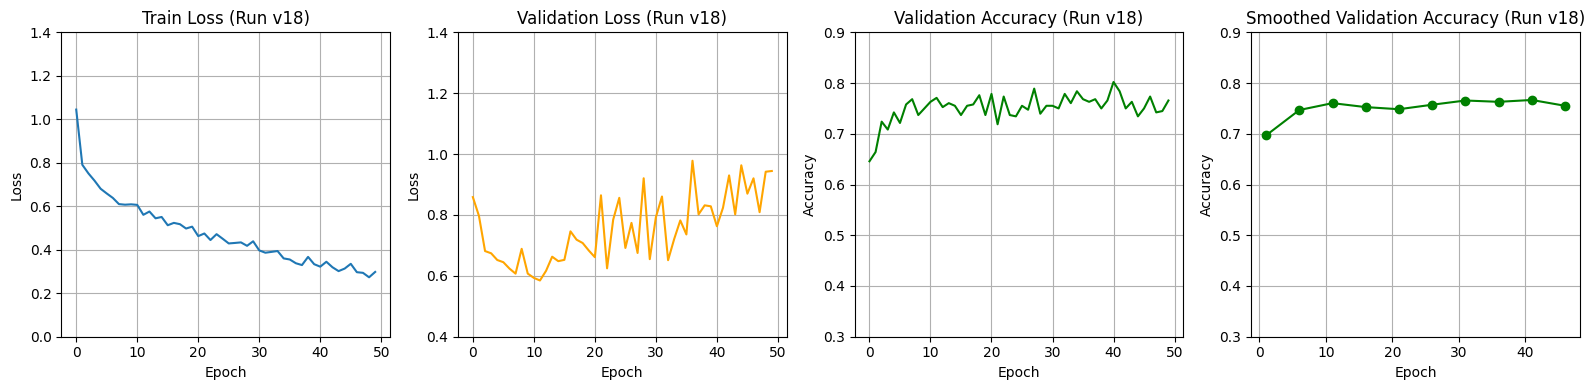

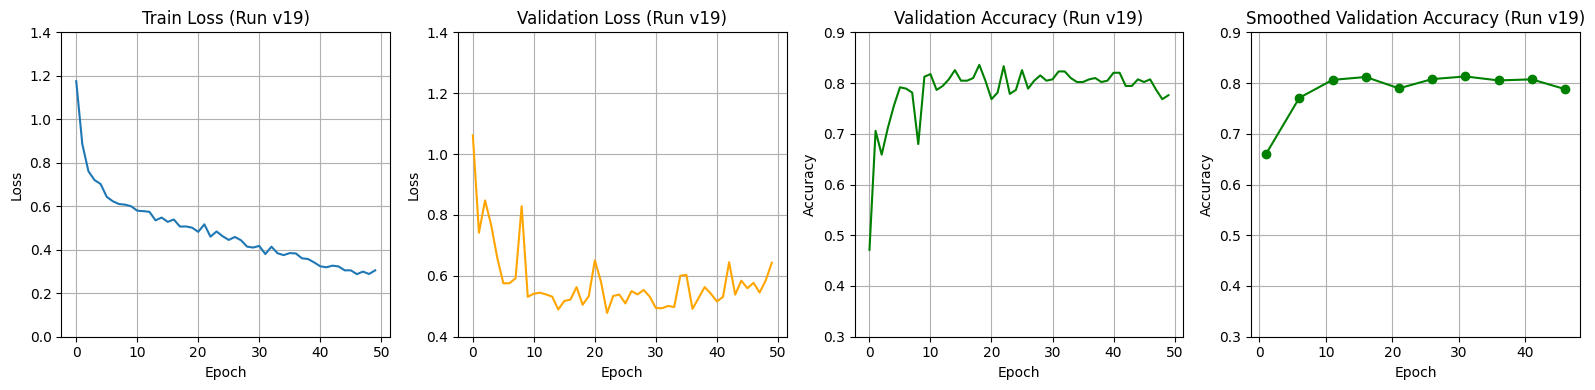

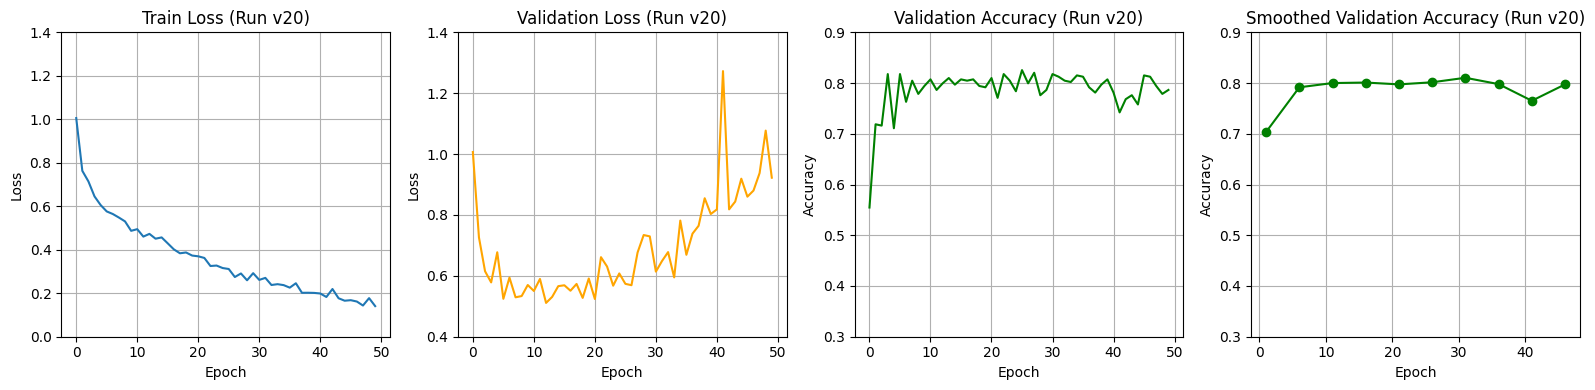

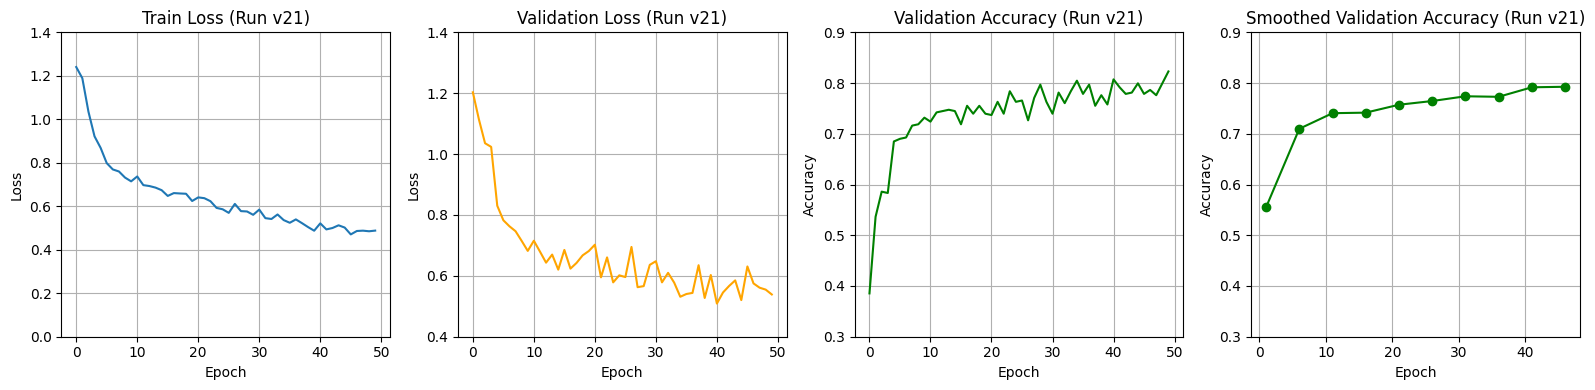

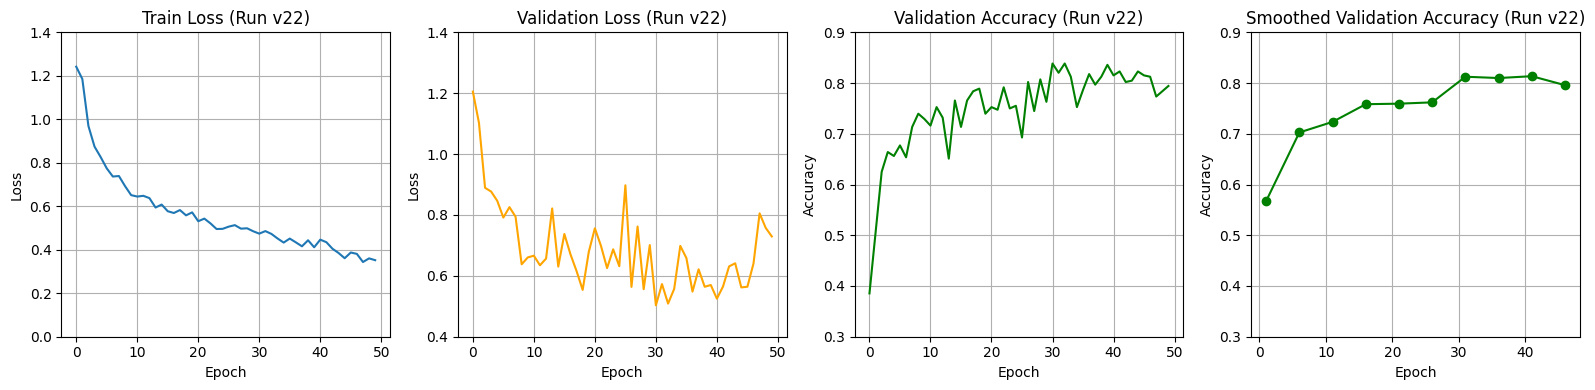

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

# Grouped average function
def grouped_average(values, group_size):
    return [np.mean(values[i:i + group_size]) for i in range(0, len(values), group_size)]

group_size = 5  # average over 5 epochs

histories = []
versions = []

# Sort by version number 
jsons = sorted(
    path.glob('*.json'),
    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
)

# Read data and record version numbers
for json_file in jsons:
    version = int(re.search(r'v(\d+)', json_file.name).group(1))
    versions.append(version)
    with open(json_file, 'r') as file:
        histories.append(json.loads(file.read()))

stats = {}
for history in histories:
    for key, values in history.items():
        if isinstance(values, list) and all(isinstance(v, (int, float)) for v in values):
            if key not in stats:
                stats[key] = {"min": float("inf"), "max": float("-inf")}
            stats[key]["min"] = min(stats[key]["min"], min(values))
            stats[key]["max"] = max(stats[key]["max"], max(values))

for history, version in zip(histories, versions):
    val_acc = history['val_acc']
    val_acc_grouped = grouped_average(val_acc, group_size)
    val_acc_epochs = [i + 1 for i in range(0, len(val_acc), group_size)]

    plt.figure(figsize=(16, 4))

    # Loss
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run v{version})')  # Use real version number
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
#    plt.ylim(0.5, 1.2) 
    plt.ylim(np.floor(stats['loss']["min"] / 0.2) * 0.2,np.ceil(stats['loss']["max"] / 0.2) * 0.2)
    #print(stats['loss']["min"])
    #print(stats['loss']["min"])
    #print(np.floor(stats['loss']["min"] / 0.2) * 0.2)
    #print(np.ceil(stats['loss']["min"] / 0.2) * 0.2)
    # Val loss
    plt.subplot(1, 4, 2)
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'Validation Loss (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(np.floor(stats['val_loss']["min"] / 0.2) * 0.2,np.ceil(stats['val_loss']["max"] / 0.2) * 0.2)
    #    plt.ylim(0.8,1.2)

    plt.subplot(1, 4, 3)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(np.floor(stats['val_acc']["min"] / 0.1) * 0.1,np.ceil(stats['val_acc']["max"] / 0.1) * 0.1)
    # plt.ylim(0.5, 0.7)

    # Smoothed val accuracy
    plt.subplot(1, 4, 4)
    plt.plot(val_acc_epochs, val_acc_grouped, label='Val Acc (Avg/5)', color='green', marker='o')
    plt.title(f'Smoothed Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(np.floor(stats['val_acc']["min"] / 0.1) * 0.1,np.ceil(stats['val_acc']["max"] / 0.1) * 0.1)
    #plt.ylim(0.5, 0.7)
    
    plt.tight_layout()
    plt.show()


In [9]:
import re
import json
import pandas as pd
from pathlib import Path

path = pathv5

path = Path(path)

jsons = sorted(
    path.glob("*.json"),
    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
)

versions = []
histories = []

for json_file in jsons:
    version = int(re.search(r'v(\d+)', json_file.name).group(1))
    versions.append(version)
    with open(json_file, "r") as file:
        jf = json.load(file)
        histories.append(jf)
        print(jf)

metrics = ["loss", "val_loss", "val_acc"]

with pd.ExcelWriter("merged_histories_semiPretrainTransfer.xlsx") as writer:
    for metric in metrics:
        columns = {}
        max_len = 0
        for version, history in zip(versions, histories):
            values = history.get(metric, [])
            max_len = max(max_len, len(values))
            columns[f"v{version}"] = values
        # pad with NaN to equalize lengths
        for key in columns:
            pad_len = max_len - len(columns[key])
            if pad_len > 0:
                columns[key] = columns[key] + [np.nan]*pad_len
        df = pd.DataFrame(columns)
        df.to_excel(writer, sheet_name=metric, index=False)

{'loss': [1.2742379043413246, 1.1757490073425183, 1.1364153530286707, 1.1003081228422082, 1.0657640125440515, 1.0493770222732985, 1.019262401090152, 0.9995059973951699, 0.9953149636586507, 0.9780688615812771, 0.9619864349779875, 0.9533168458420297, 0.9403879352237867, 0.9338182354318922, 0.9137557428816091, 0.8948168409043464, 0.8960065566975137, 0.8764379642147949, 0.8659872886927231, 0.8535000286240508, 0.8496180470438971, 0.8349386507186337, 0.8337894224602244, 0.809004686448885, 0.8002173688100732, 1.060836710035801, 0.7877629809081554, 0.7328010387718678, 0.7007513605058193, 0.6653399579226971, 0.6370639093220234, 0.6060077715665102, 0.5969618484377861, 0.5815890282392502, 0.5539660360664129, 0.5448311548680067, 0.5363873317837715, 0.5130544845014811, 0.50218490883708, 0.4654031414538622, 0.4504110272973776, 0.4715244136750698, 0.427979176864028, 0.4364351313561201, 0.40720017813146114, 0.4075093138962984, 0.3830673648044467, 0.3815957736223936, 0.3687892183661461, 0.3497339738532

In [5]:
import json

# Find min and max for each key across all histories
stats = {}
for history in histories:
    for key, values in history.items():
        if isinstance(values, list) and all(isinstance(v, (int, float)) for v in values):
            if key not in stats:
                stats[key] = {"min": float("inf"), "max": float("-inf")}
            stats[key]["min"] = min(stats[key]["min"], min(values))
            stats[key]["max"] = max(stats[key]["max"], max(values))

print(stats)


{'loss': {'min': 0.27743866559312563, 'max': 1.1849204028646152}, 'val_loss': {'min': 0.5273789649897177, 'max': 1.1133653283222884}, 'val_acc': {'min': 0.5208333333333334, 'max': 0.8255208333333334}}
